# Stunting Prediction - Complete Analysis Pipeline

This notebook provides a comprehensive pipeline for stunting prediction, including:
1. Data loading and exploration
2. Data preprocessing and feature engineering
3. Model training and evaluation
4. Visualization of results
5. Model inference on new data

The notebook is designed to be self-contained and includes all necessary code for the complete machine learning workflow.

## 1. Import Libraries and Setup

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import joblib
import warnings
from pathlib import Path

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Set up visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings("ignore")

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {joblib.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4
Scikit-learn version: 1.5.2


## 2. Data Loading and Initial Exploration

In [2]:
# Load the dataset
data_path = 'stunting_wasting_dataset.csv'
print(f"Loading data from: {data_path}")

try:
    df = pd.read_csv(data_path)
    print(f"✓ Dataset loaded successfully!")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print(f"❌ Error: File '{data_path}' not found. Please check the file path.")
    # Create a sample dataset for demonstration if file doesn't exist
    print("Creating a sample dataset for demonstration...")
    np.random.seed(42)
    sample_size = 1000
    df = pd.DataFrame({
        'Age': np.random.randint(6, 60, sample_size),
        'Gender': np.random.choice(['Male', 'Female'], sample_size),
        'Weight': np.random.normal(15, 5, sample_size),
        'Height': np.random.normal(100, 20, sample_size),
        'BMI': np.random.normal(15, 3, sample_size),
        'Region': np.random.choice(['Urban', 'Rural'], sample_size),
        'Education': np.random.choice(['Primary', 'Secondary', 'Higher'], sample_size),
        'Income': np.random.normal(5000, 2000, sample_size),
        'Stunting': np.random.choice([0, 1], sample_size, p=[0.7, 0.3])
    })
    print(f"Sample dataset created with shape: {df.shape}")

Loading data from: stunting_wasting_dataset.csv
✓ Dataset loaded successfully!
Shape: 100000 rows, 6 columns


In [3]:
# Display basic information about the dataset
print("\n=== Dataset Information ===")
print(df.info())

print("\n=== First 5 Rows ===")
display(df.head())

print("\n=== Statistical Summary ===")
display(df.describe(include='all'))

print("\n=== Missing Values ===")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
display(missing_df[missing_df['Missing Count'] > 0])


=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB
None

=== First 5 Rows ===


,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight



=== Statistical Summary ===


,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
count,100000,100000.000000,100000.000000,100000.000000,100000,100000
unique,2,NaN,NaN,NaN,4,4
top,Laki-laki,NaN,NaN,NaN,Normal,Risk of Overweight
freq,50179,NaN,NaN,NaN,72312,41897
mean,NaN,11.992580,73.132657,9.259256,NaN,NaN
std,NaN,7.199671,11.360846,3.300780,NaN,NaN
min,NaN,0.000000,42.600000,1.000000,NaN,NaN
25%,NaN,6.000000,65.500000,6.900000,NaN,NaN
50%,NaN,12.000000,74.200000,9.200000,NaN,NaN
75%,NaN,18.000000,81.400000,11.700000,NaN,NaN



=== Missing Values ===


,Missing Count,Missing Percentage


## 3. Data Preprocessing and Feature Engineering

In [4]:
# Clean column names
def clean_column_names(df):
    """Clean column names by removing spaces and special characters"""
    df.columns = [re.sub(r"\s+", "_", str(c).strip()) for c in df.columns]
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    return df

df = clean_column_names(df)
print("✓ Column names cleaned")
print(f"Columns: {list(df.columns)}")

✓ Column names cleaned
Columns: ['Jenis_Kelamin', 'Umur_(bulan)', 'Tinggi_Badan_(cm)', 'Berat_Badan_(kg)', 'Stunting', 'Wasting']


In [5]:
# Identify and remove ID-like columns
def is_id_like(column_name):
    """Check if a column name suggests it's an ID column"""
    return bool(re.search(r"(?:^id$|_id$|^no$|^no_|_no$|^index$|nik|nkk|uuid)", column_name, flags=re.I))

id_columns = [c for c in df.columns if is_id_like(c)]
print(f"Identified ID columns: {id_columns}")

# Remove ID columns
df_cleaned = df.drop(columns=id_columns, errors='ignore')
print(f"✓ Removed {len(id_columns)} ID columns")
print(f"New shape: {df_cleaned.shape}")

Identified ID columns: []
✓ Removed 0 ID columns
New shape: (100000, 6)


In [6]:
# Drop columns with all missing values
df_cleaned = df_cleaned.dropna(axis=1, how='all')
print(f"✓ Dropped columns with all missing values")
print(f"New shape: {df_cleaned.shape}")

✓ Dropped columns with all missing values
New shape: (100000, 6)


In [7]:
# Target variable preprocessing
def to_binary_target(y_raw, positive_labels=None, negative_labels=None):
    """
    Convert target variable to binary format, explicitly mapping stunting vs non-stunting.

    Parameters
    ----------
    y_raw : array-like
        Original target column (e.g. 'Stunting').
    positive_labels : list of str, optional
        Labels that should be mapped to 1 (stunting).
    negative_labels : list of str, optional
        Labels that should be mapped to 0 (tidak stunting).
    """
    s = pd.Series(y_raw).astype(str).str.strip().str.lower()
    
    # Default mapping khusus untuk konteks stunting anak
    if positive_labels is None:
        positive_labels = [
            "stunted", "severely stunted", "sangat pendek", "pendek", "stunting",
        ]
    if negative_labels is None:
        negative_labels = [
            "normal", "tall", "tinggi", "risk of overweight", "overweight", "obese",
        ]
    
    mapping = {}
    for v in positive_labels:
        mapping[v] = 1
    for v in negative_labels:
        mapping[v] = 0
    
    # Map exact match dulu
    y = s.map(mapping)
    
    # Jika masih ada label lain, jatuhkan ke label mayoritas (anggap non-stunting = 0)
    if y.isna().any():
        # label yang belum terpetakan
        remaining = s[y.isna()]
        if not remaining.empty:
            # majority vote di remaining, lalu treat majority sebagai kelas 0
            le = LabelEncoder().fit(remaining)
            lab = le.transform(remaining)
            maj = pd.Series(lab).value_counts().idxmax()
            maj_label = le.inverse_transform([maj])[0]
            maj_label = str(maj_label).strip().lower()
            # anggap mayoritas remaining sebagai non-stunting
            mapping[maj_label] = 0
            y = s.map(mapping)
    
    # Fallback terakhir: kalau tetap tidak biner, paksa dengan majority baseline
    if y.isna().any() or len(pd.Series(y).dropna().unique()) > 2:
        lab = LabelEncoder().fit_transform(s)
        maj = pd.Series(lab).value_counts().idxmax()
        y = (lab != maj).astype(int)
    
    return pd.Series(y, index=s.index).astype(int)

# Identify target column
target_column = 'Stunting' if 'Stunting' in df_cleaned.columns else df_cleaned.columns[-1]
print(f"Target column: {target_column}")

# Convert target to binary (stunting vs tidak stunting)
y = to_binary_target(df_cleaned[target_column])
print(f"✓ Target converted to binary (1 = stunting, 0 = tidak stunting)")
print("Target distribution:")
print(y.value_counts())
print(f"Percentage of positive (stunting) cases: {y.mean():.2%}")

Target column: Stunting
✓ Target converted to binary (1 = stunting, 0 = tidak stunting)
Target distribution:
Stunting
0    78021
1    21979
Name: count, dtype: int64
Percentage of positive (stunting) cases: 21.98%


In [8]:
# Separate features and target
X = df_cleaned.drop(columns=[target_column], errors='ignore')
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (100000, 5)
Target shape: (100000,)


In [9]:
# Identify numerical and categorical columns
numerical_columns = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_columns = [c for c in X.columns if c not in numerical_columns]

print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

Numerical columns (3): ['Umur_(bulan)', 'Tinggi_Badan_(cm)', 'Berat_Badan_(kg)']
Categorical columns (2): ['Jenis_Kelamin', 'Wasting']


## 4. Data Visualization

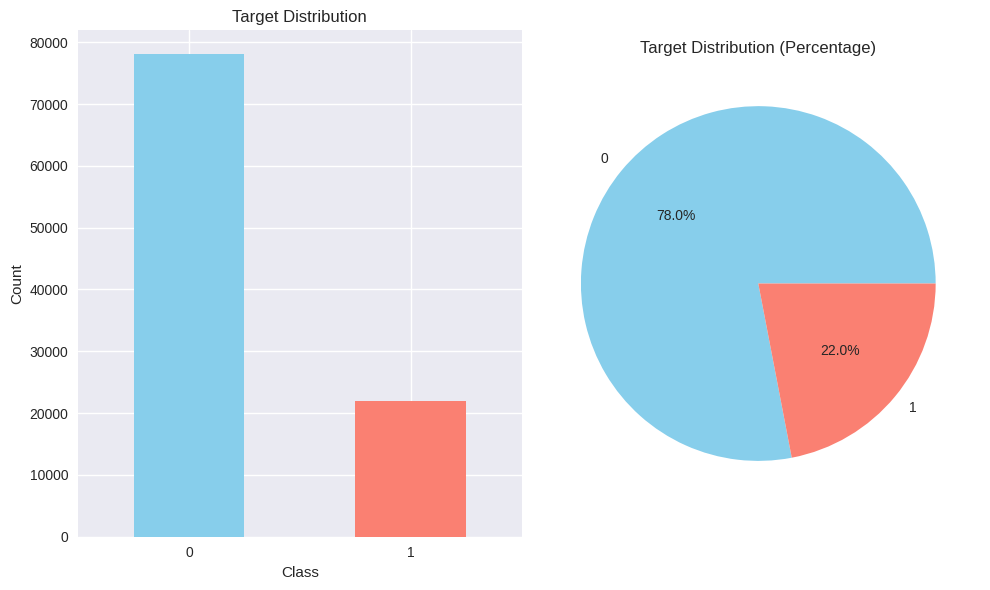

In [10]:
# Visualize target distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
y.value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Target Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.show()

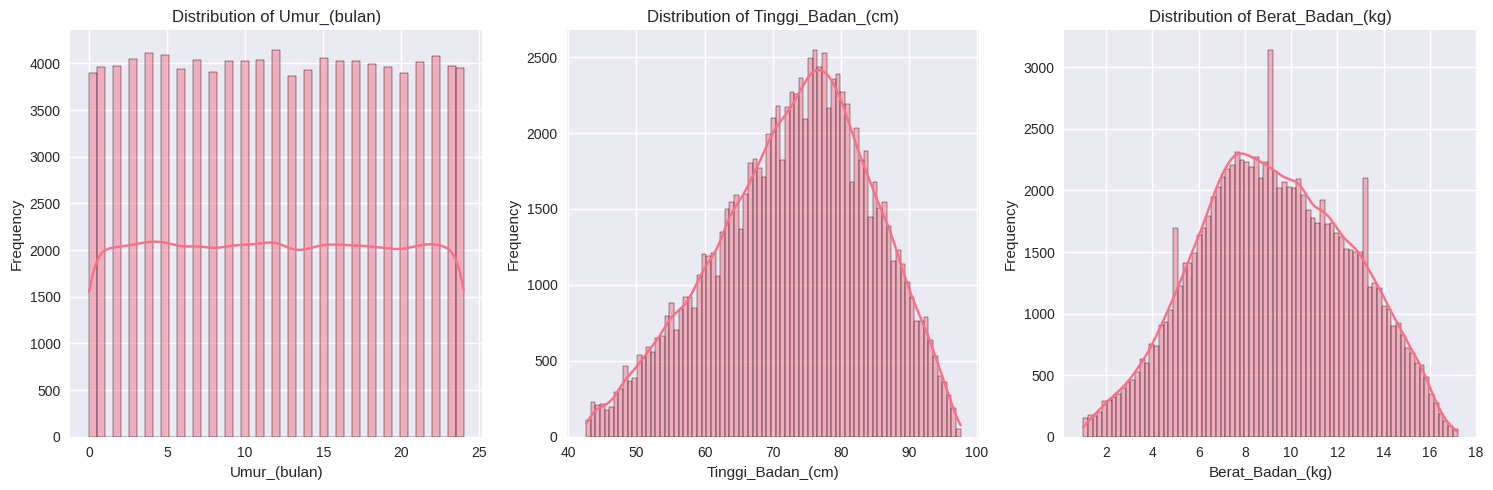

In [11]:
# Visualize numerical features
if numerical_columns:
    n_cols = min(3, len(numerical_columns))
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(numerical_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(data=X, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns to visualize")

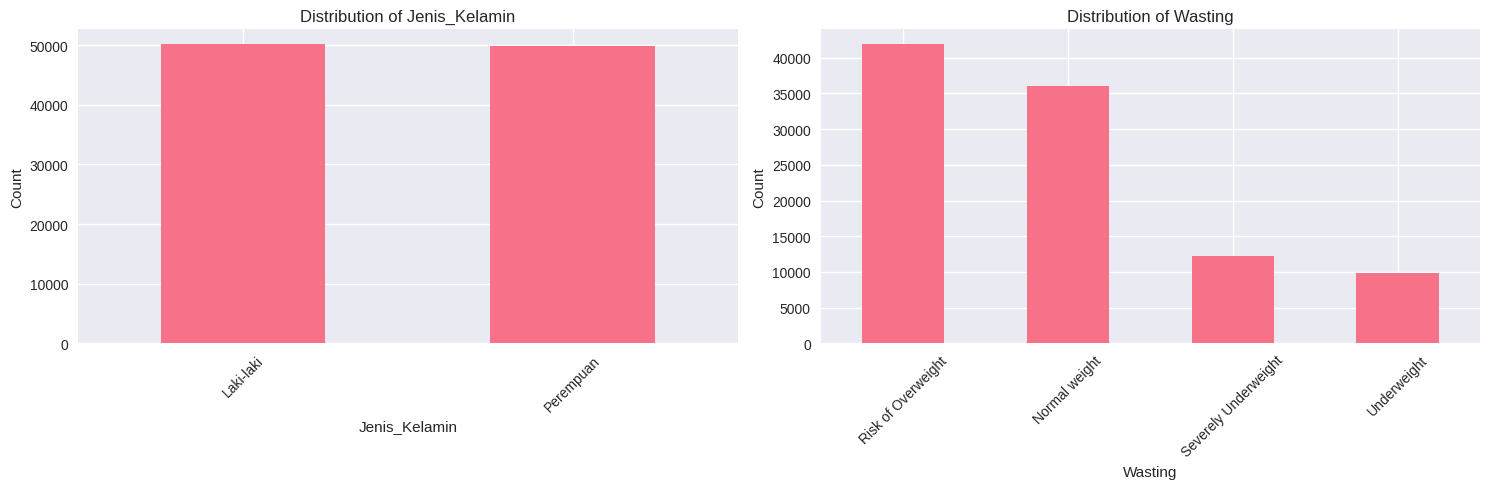

In [12]:
# Visualize categorical features
if categorical_columns:
    n_cols = min(3, len(categorical_columns))
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(categorical_columns, 1):
        plt.subplot(n_rows, n_cols, i)
        X[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns to visualize")

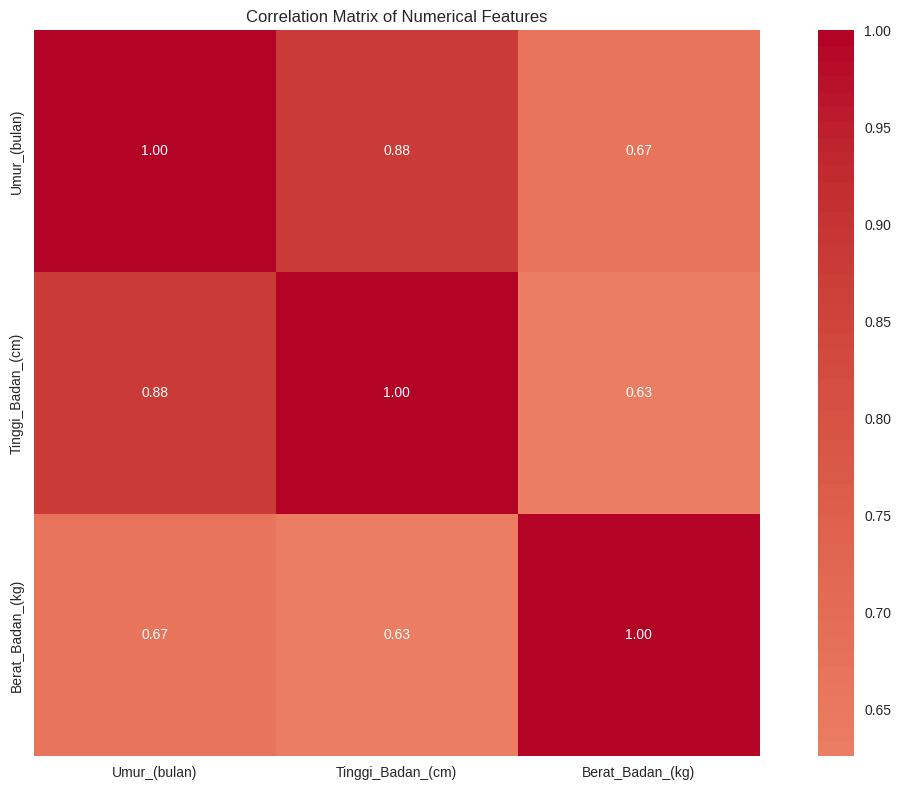

In [13]:
# Correlation matrix for numerical features
if len(numerical_columns) > 1:
    plt.figure(figsize=(12, 8))
    correlation_matrix = X[numerical_columns].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical columns for correlation matrix")

## 5. Data Preprocessing Pipeline

In [14]:
# Create preprocessing pipelines
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Create column transformer
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)
], remainder='drop', sparse_threshold=0.3)

print("✓ Preprocessing pipeline created")
print(f"Numerical features: {len(numerical_columns)}")
print(f"Categorical features: {len(categorical_columns)}")

✓ Preprocessing pipeline created
Numerical features: 3
Categorical features: 2


## 6. Train-Test Split

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=171
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print("Training target distribution:")
print(y_train.value_counts(normalize=True))
print("Test target distribution:")
print(y_test.value_counts(normalize=True))

Training set size: 80000 samples
Test set size: 20000 samples
Training target distribution:
Stunting
0    0.780212
1    0.219787
Name: proportion, dtype: float64
Test target distribution:
Stunting
0    0.7802
1    0.2198
Name: proportion, dtype: float64


## 7. Model Training and Evaluation

In [16]:
# Define models
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=150, 
            class_weight='balanced_subsample', 
            random_state=42, 
            n_jobs=-1
        ))
    ])
}

print(f"✓ Defined {len(models)} models for training")

✓ Defined 2 models for training


In [17]:
# Train and evaluate models
results = []
trained_models = {}
classification_reports = {}
confusion_matrices = {}

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Get prediction probabilities
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        auc_score = float('nan')
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC AUC': auc_score
    }
    
    results.append(metrics)
    classification_reports[name] = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")
    if not np.isnan(auc_score):
        print(f"ROC AUC: {auc_score:.4f}")


=== Training Logistic Regression ===
Accuracy: 0.9136
Precision: 0.8596
Recall: 0.9274
F1-Score: 0.8855
ROC AUC: 0.9718

=== Training Random Forest ===
Accuracy: 0.9991
Precision: 0.9989
Recall: 0.9986
F1-Score: 0.9988
ROC AUC: 1.0000



=== Model Comparison ===


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.91360,0.859598,0.927392,0.885544,0.971787
1,Random Forest,0.99915,0.998883,0.998638,0.998761,0.999997


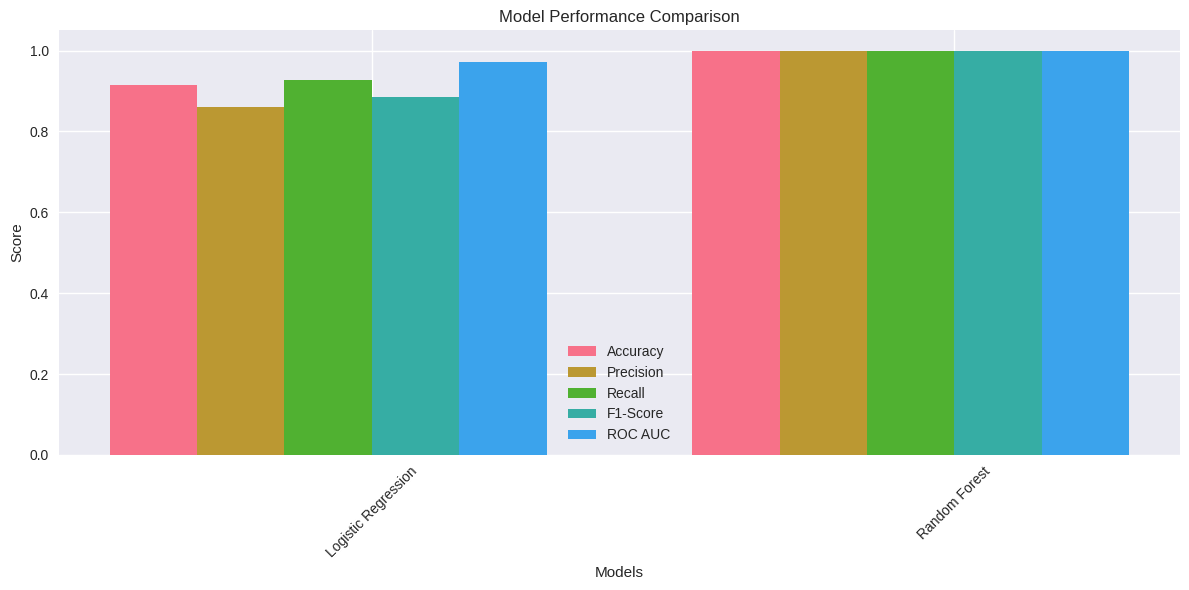

In [18]:
# Display results comparison
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
display(results_df)

# Visualize model comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
if not results_df['ROC AUC'].isna().all():
    metrics_to_plot.append('ROC AUC')

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Model']))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x + width * len(metrics_to_plot) / 2, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 8. Visualisasi Hasil Model
Pada bagian ini dilakukan visualisasi kinerja model, termasuk:
- Perbandingan skor metrik utama antar model
- Visualisasi confusion matrix untuk model terbaik
- Kurva ROC untuk model terbaik
- Perbandingan nilai aktual vs prediksi pada subset data uji

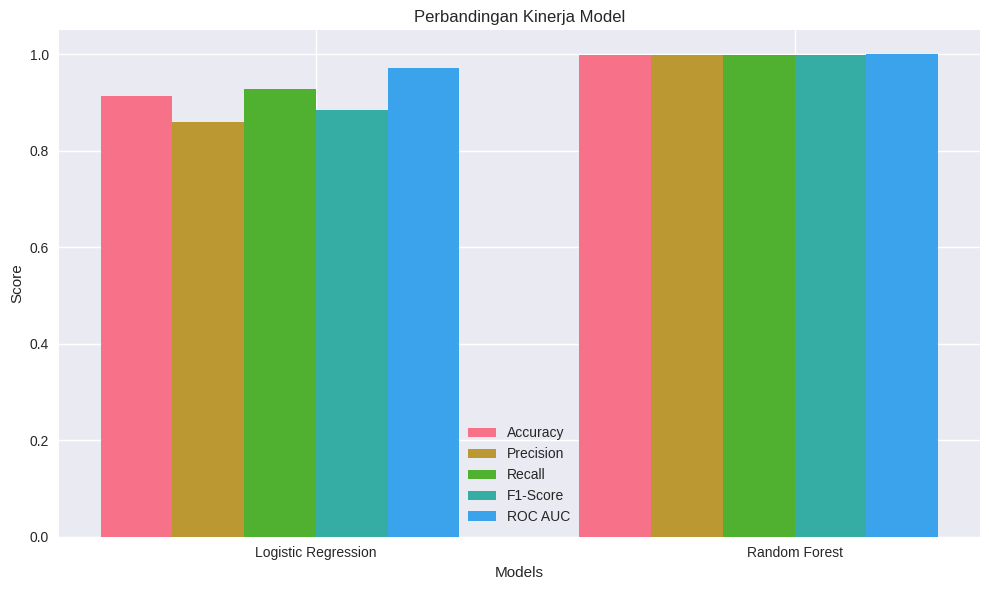

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.914,0.860,0.927,0.886,0.972
1,Random Forest,0.999,0.999,0.999,0.999,1.000


In [19]:
# 8.1 Visualisasi Perbandingan Skor Model
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
if not results_df['ROC AUC'].isna().all():
    metrics_to_plot.append('ROC AUC')

plt.figure(figsize=(10, 6))
x = np.arange(len(results_df['Model']))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, results_df[metric], width, label=metric)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Perbandingan Kinerja Model')
plt.xticks(x + width * len(metrics_to_plot) / 2, results_df['Model'], rotation=0)
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

# 8.1b Tabel Ringkas Metrik (dibulatkan 3 desimal untuk laporan)
display(results_df.round(3))

<Figure size 500x400 with 0 Axes>

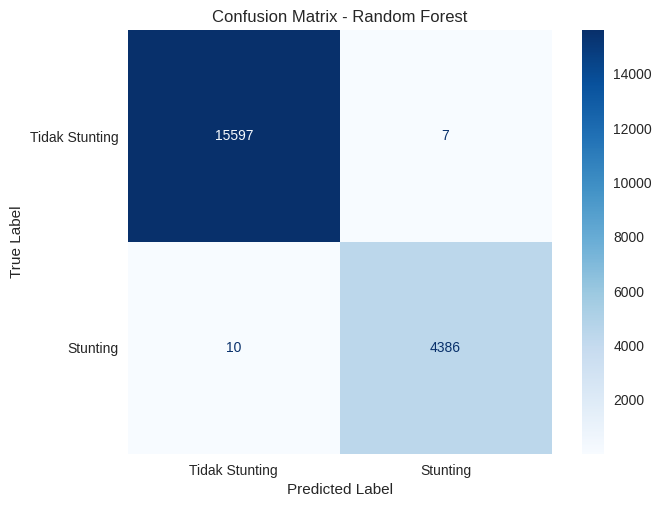

In [20]:
# 8.2 Confusion Matrix untuk Model Terbaik
from sklearn.metrics import ConfusionMatrixDisplay

best_model_name = results_df.sort_values('F1-Score', ascending=False).iloc[0]['Model']
best_model = trained_models[best_model_name]
cm = confusion_matrices[best_model_name]

plt.figure(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tidak Stunting', 'Stunting'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()

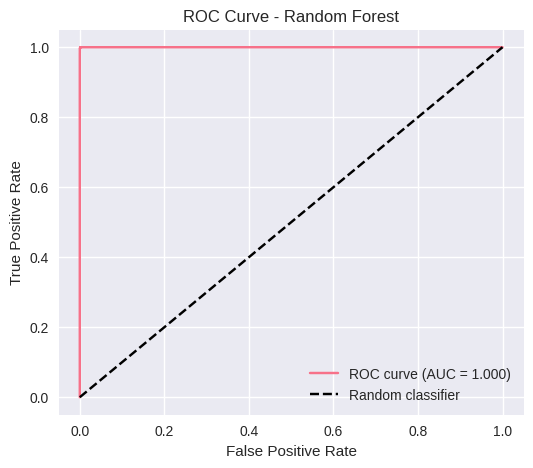

In [21]:
# 8.3 Kurva ROC untuk Model Terbaik
from sklearn.metrics import roc_curve, roc_auc_score

best_model_name = results_df.sort_values('F1-Score', ascending=False).iloc[0]['Model']
best_model = trained_models[best_model_name]

if hasattr(best_model, 'predict_proba') and best_model.predict_proba(X_test).shape[1] == 2:
    y_scores = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_score = roc_auc_score(y_test, y_scores)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
else:
    print(f"Model {best_model_name} tidak mendukung predict_proba biner yang valid.")

In [22]:
# 8.4 Perbandingan Aktual vs Prediksi pada Subset Data Uji
n_samples = 50
subset_X = X_test.head(n_samples)
subset_y_true = y_test.head(n_samples)
subset_y_pred = best_model.predict(subset_X)

comparison_df = subset_X.copy()
comparison_df['Actual'] = subset_y_true.values
comparison_df['Predicted'] = subset_y_pred

print(f"Menampilkan {n_samples} sampel pertama dari data uji dengan label aktual dan prediksi:")
display(comparison_df[['Actual', 'Predicted']].head(20))

Menampilkan 50 sampel pertama dari data uji dengan label aktual dan prediksi:


,Actual,Predicted
75654,1,1
26986,0,0
90802,0,0
67907,0,0
8475,0,0
15272,0,0
26933,0,0
74035,1,1
84574,0,0
82608,1,1


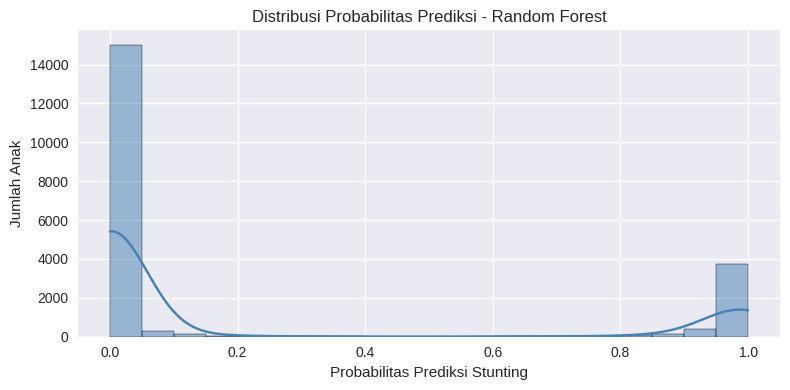


Jumlah False Positive: 7


,Jenis_Kelamin,Umur_(bulan),Tinggi_Badan_(cm),Berat_Badan_(kg),Wasting,Actual,Predicted,Prob_Stunting
19389,Laki-laki,13,72.2,7.6,Underweight,0,1,0.586667
1779,Perempuan,2,53.0,3.0,Severely Underweight,0,1,0.540000
64102,Perempuan,14,71.4,6.7,Underweight,0,1,0.526667
19111,Perempuan,16,73.0,14.0,Risk of Overweight,0,1,0.560000
4384,Laki-laki,5,62.0,5.7,Underweight,0,1,0.533333
88512,Perempuan,14,71.0,6.7,Underweight,0,1,0.753333
59474,Perempuan,10,66.5,5.7,Severely Underweight,0,1,0.513333



Jumlah False Negative: 10


,Jenis_Kelamin,Umur_(bulan),Tinggi_Badan_(cm),Berat_Badan_(kg),Wasting,Actual,Predicted,Prob_Stunting
80366,Perempuan,17,73.9,12.8,Risk of Overweight,1,0,0.406667
69656,Perempuan,4,57.7,4.5,Underweight,1,0,0.380000
36829,Perempuan,24,82.8,8.5,Underweight,1,0,0.400000
71604,Perempuan,10,66.3,5.4,Severely Underweight,1,0,0.473333
34976,Laki-laki,2,54.3,4.0,Underweight,1,0,0.333333
45077,Perempuan,17,73.9,14.4,Risk of Overweight,1,0,0.360000
45187,Laki-laki,8,66.1,5.9,Severely Underweight,1,0,0.493333
51279,Perempuan,17,73.9,7.0,Underweight,1,0,0.440000
92460,Perempuan,11,67.6,6.2,Underweight,1,0,0.353333
38426,Perempuan,24,82.8,8.1,Underweight,1,0,0.346667


In [23]:
# 8.5 Distribusi Probabilitas Prediksi Model Terbaik
if hasattr(best_model, 'predict_proba') and best_model.predict_proba(X_test).shape[1] == 2:
    y_scores = best_model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 4))
    sns.histplot(y_scores, bins=20, kde=True, color='steelblue')
    plt.xlabel('Probabilitas Prediksi Stunting')
    plt.ylabel('Jumlah Anak')
    plt.title(f'Distribusi Probabilitas Prediksi - {best_model_name}')
    plt.tight_layout()
    plt.show()
else:
    print(f"Model {best_model_name} tidak mendukung predict_proba biner yang valid.")


# 8.6 Analisis Error: False Positive dan False Negative
y_pred_full = best_model.predict(X_test)
comparison_full = X_test.copy()
comparison_full['Actual'] = y_test.values
comparison_full['Predicted'] = y_pred_full
comparison_full['Prob_Stunting'] = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') and best_model.predict_proba(X_test).shape[1] == 2 else np.nan


# False Positive: model memprediksi stunting (1) padahal aktual 0
false_positives = comparison_full[(comparison_full['Actual'] == 0) & (comparison_full['Predicted'] == 1)]
print(f"\nJumlah False Positive: {len(false_positives)}")
display(false_positives.head(10))


# False Negative: model memprediksi tidak stunting (0) padahal aktual 1 (lebih berisiko secara klinis)
false_negatives = comparison_full[(comparison_full['Actual'] == 1) & (comparison_full['Predicted'] == 0)]
print(f"\nJumlah False Negative: {len(false_negatives)}")
display(false_negatives.head(10))

In [24]:
# 8.6 Analisis Error: False Positive dan False Negative
y_pred_full = best_model.predict(X_test)
comparison_full = X_test.copy()
comparison_full['Actual'] = y_test.values
comparison_full['Predicted'] = y_pred_full
comparison_full['Prob_Stunting'] = (
    best_model.predict_proba(X_test)[:, 1]
    if hasattr(best_model, 'predict_proba') and best_model.predict_proba(X_test).shape[1] == 2
    else np.nan
)

# False Positive: model memprediksi stunting (1) padahal aktual 0
false_positives = comparison_full[(comparison_full['Actual'] == 0) & (comparison_full['Predicted'] == 1)]
print(f"\nJumlah False Positive: {len(false_positives)}")
display(false_positives.head(10))

# False Negative: model memprediksi tidak stunting (0) padahal aktual 1 (lebih berisiko secara klinis)
false_negatives = comparison_full[(comparison_full['Actual'] == 1) & (comparison_full['Predicted'] == 0)]
print(f"\nJumlah False Negative: {len(false_negatives)}")
display(false_negatives.head(10))


Jumlah False Positive: 7


,Jenis_Kelamin,Umur_(bulan),Tinggi_Badan_(cm),Berat_Badan_(kg),Wasting,Actual,Predicted,Prob_Stunting
19389,Laki-laki,13,72.2,7.6,Underweight,0,1,0.586667
1779,Perempuan,2,53.0,3.0,Severely Underweight,0,1,0.540000
64102,Perempuan,14,71.4,6.7,Underweight,0,1,0.526667
19111,Perempuan,16,73.0,14.0,Risk of Overweight,0,1,0.560000
4384,Laki-laki,5,62.0,5.7,Underweight,0,1,0.533333
88512,Perempuan,14,71.0,6.7,Underweight,0,1,0.753333
59474,Perempuan,10,66.5,5.7,Severely Underweight,0,1,0.513333



Jumlah False Negative: 10


,Jenis_Kelamin,Umur_(bulan),Tinggi_Badan_(cm),Berat_Badan_(kg),Wasting,Actual,Predicted,Prob_Stunting
80366,Perempuan,17,73.9,12.8,Risk of Overweight,1,0,0.406667
69656,Perempuan,4,57.7,4.5,Underweight,1,0,0.380000
36829,Perempuan,24,82.8,8.5,Underweight,1,0,0.400000
71604,Perempuan,10,66.3,5.4,Severely Underweight,1,0,0.473333
34976,Laki-laki,2,54.3,4.0,Underweight,1,0,0.333333
45077,Perempuan,17,73.9,14.4,Risk of Overweight,1,0,0.360000
45187,Laki-laki,8,66.1,5.9,Severely Underweight,1,0,0.493333
51279,Perempuan,17,73.9,7.0,Underweight,1,0,0.440000
92460,Perempuan,11,67.6,6.2,Underweight,1,0,0.353333
38426,Perempuan,24,82.8,8.1,Underweight,1,0,0.346667
